# ViT-B-16

- Channels can be visualised after direct logit attribution to find maximally activating channels for a given class.

Issues:

- There is no prior work I can compare these visualisations to but there are an extremely high number of high-frequency artifacts in the visualisations pointing to potentially ineffective transforms.
- There are 12 attention heads in ViT-B-16 but the activations for the attention query,key and values are of the shape [1,197,768] when I would expect them to be [1,12,197,768]. Where are the activations for all the heads stored?
- Transformers don't follow the same execution logic as ResNets and there might need to be a change in the procedure I'm using currently which is the exact same as for Resnet-18 in the previous section. I would appreciate any guidance in this regard. 

## Setup and helper functions

In [ ]:
!pip install --quiet git+https://github.com/atagade/lucent

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import urllib.request 
import numpy as np
import collections
from functools import partial
from PIL import Image
from lucent.modelzoo import custom_resnet
from lucent.optvis import objectives, transform, param, render
from lucent.optvis.render import hook_model
from transformers import ViTImageProcessor, ViTForImageClassification

In [ ]:
import urllib.request  # the lib that handles the url stuff
labels_str = ""
for line in urllib.request.urlopen("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt"):
    labels_str += line.decode('utf-8')
labels = [line[line.find(" "):].strip() for line in labels_str.split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

In [ ]:
!wget https://distill.pub/2018/building-blocks/examples/input_images/dog_cat.jpeg

--2023-05-11 04:27:57--  https://distill.pub/2018/building-blocks/examples/input_images/dog_cat.jpeg
Resolving distill.pub (distill.pub)... 151.101.1.195, 151.101.65.195
Connecting to distill.pub (distill.pub)|151.101.1.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17153 (17K) [image/jpeg]
Saving to: ‘dog_cat.jpeg.1’

dog_cat.jpeg.1      100%[===================>]  16.75K  --.-KB/s    in 0s      

2023-05-11 04:27:57 (132 MB/s) - ‘dog_cat.jpeg.1’ saved [17153/17153]



In [ ]:
def raw_class_spatial_attr(img, layer, label, transforms=None, override=None):
  """How much did spatial positions at a given layer effect a output class?"""

  attrs = []
  img = torch.tensor(np.transpose(img, [2, 0, 1])).to('cpu')
  normalize = (
      transform.preprocess_inceptionv1()
      if model._get_name() == "InceptionV1"
      else transform.normalize()
  )
  transforms = [
      normalize,
      torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
  ]

  transforms_f = transform.compose(transforms)
  img = img.unsqueeze(0)
  img = transforms_f(img)
  
  scores = model.forward(img)

  acts = activations[layer.replace('_','.')][0]
  score = scores.logits[0, labels.index(label)]
  grad = torch.autograd.grad(score, acts)[0]
  attr = torch.sum(acts[0] * grad, axis = -1)

  return attr

## Maximally activating channels in layer 0

### Labrador retriever

In [ ]:
channel_list = []
layer = '0'
layers = [ 'vit_encoder_layer_'+layer+'_attention_attention_query',
 'vit_encoder_layer_'+layer+'_attention_attention_key',
 'vit_encoder_layer_'+layer+'_attention_attention_value',
 'vit_encoder_layer_'+layer+'_attention_attention_dropout',
 'vit_encoder_layer_'+layer+'_attention_output_dense',
 'vit_encoder_layer_'+layer+'_attention_output_dropout',
 'vit_encoder_layer_'+layer+'_intermediate_dense',
 'vit_encoder_layer_'+layer+'_output_dense',
 'vit_encoder_layer_'+layer+'_output_dropout',
 ]

label = 'Labrador retriever'

for l in layers:
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  if len(attr.shape) == 2:
    channel_list.append(attr.max(-1)[1].item())
  elif len(attr.shape) == 3:
    channel_list.append(attr.max(-1)[0].max(-1)[1].item())

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[172, 0, 171, 4, 172, 172, 185, 171, 171]


100%|██████████| 512/512 [00:24<00:00, 20.89it/s]



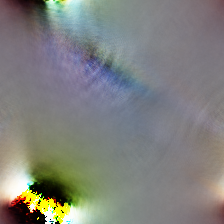
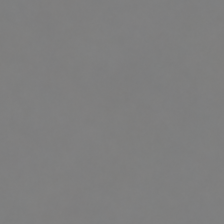
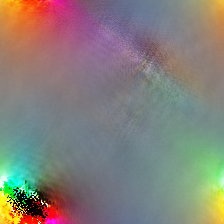
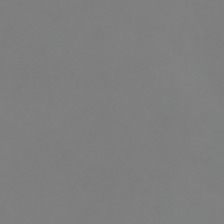
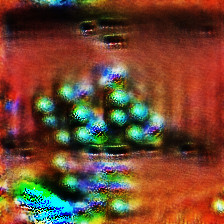
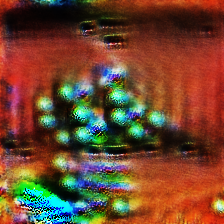
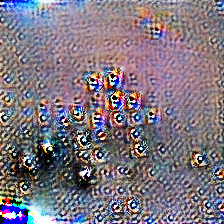
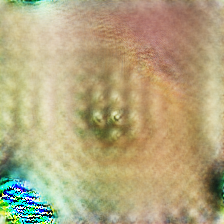
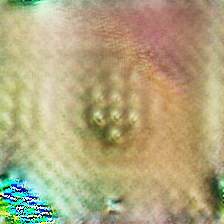
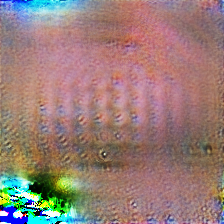

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()


param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0], batch = 0) + objectives.channel(layers[0],channel_list[0], batch = len(layers))

for i, layer in enumerate(layers):
  if i == 0:
    continue

  obj += objectives.channel(layer,channel_list[i], batch = i) + objectives.channel(layer,channel_list[i], batch = len(layers))
  
_ = render.render_vis(model, obj, param_f, preprocess = False, show_inline = True, fixed_image_size=(224,224), thresholds=(512,))

### Tiger cat

In [ ]:
channel_list = []
layer = '0'
layers = [ 'vit_encoder_layer_'+layer+'_attention_attention_query',
 'vit_encoder_layer_'+layer+'_attention_attention_key',
 'vit_encoder_layer_'+layer+'_attention_attention_value',
 'vit_encoder_layer_'+layer+'_attention_attention_dropout',
 'vit_encoder_layer_'+layer+'_attention_output_dense',
 'vit_encoder_layer_'+layer+'_attention_output_dropout',
 'vit_encoder_layer_'+layer+'_intermediate_dense',
 'vit_encoder_layer_'+layer+'_output_dense',
 'vit_encoder_layer_'+layer+'_output_dropout',
 ]

label = 'tiger cat'

for l in layers:
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  if len(attr.shape) == 2:
    channel_list.append(attr.max(-1)[1].item())
  elif len(attr.shape) == 3:
    channel_list.append(attr.max(-1)[0].max(-1)[1].item())

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[171, 157, 172, 3, 171, 171, 157, 157, 157]


100%|██████████| 512/512 [00:24<00:00, 20.91it/s]



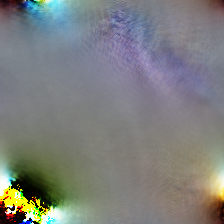
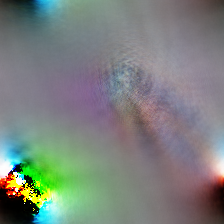
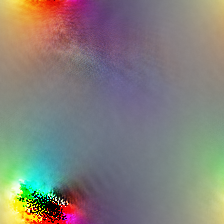
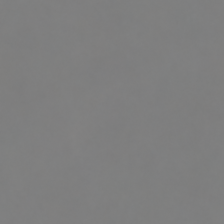
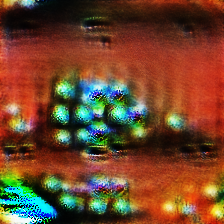
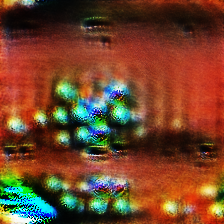
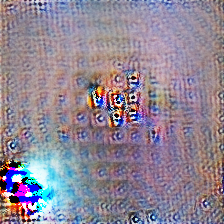
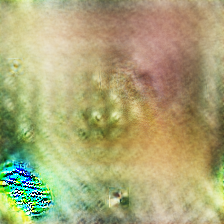
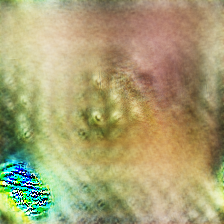
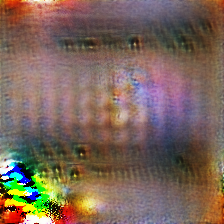

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0], batch = 0) + objectives.channel(layers[0],channel_list[0], batch = len(layers))

for i, layer in enumerate(layers):
  if i == 0:
    continue

  obj += objectives.channel(layer,channel_list[i], batch = i) + objectives.channel(layer,channel_list[i], batch = len(layers))
  
_ = render.render_vis(model, obj, param_f, preprocess = False, show_inline = True, fixed_image_size=(224,224), thresholds=(512,))

## Maximally activating channels in layer 1

### Labrador retriever

In [ ]:
channel_list = []
layer = '1'
layers = [ 'vit_encoder_layer_'+layer+'_attention_attention_query',
 'vit_encoder_layer_'+layer+'_attention_attention_key',
 'vit_encoder_layer_'+layer+'_attention_attention_value',
 'vit_encoder_layer_'+layer+'_attention_attention_dropout',
 'vit_encoder_layer_'+layer+'_attention_output_dense',
 'vit_encoder_layer_'+layer+'_attention_output_dropout',
 'vit_encoder_layer_'+layer+'_intermediate_dense',
 'vit_encoder_layer_'+layer+'_output_dense',
 'vit_encoder_layer_'+layer+'_output_dropout',
 ]

label = 'Labrador retriever'

for l in layers:
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  if len(attr.shape) == 2:
    channel_list.append(attr.max(-1)[1].item())
  elif len(attr.shape) == 3:
    channel_list.append(attr.max(-1)[0].max(-1)[1].item())

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[0, 148, 157, 4, 148, 148, 176, 176, 176]


100%|██████████| 512/512 [00:27<00:00, 18.85it/s]



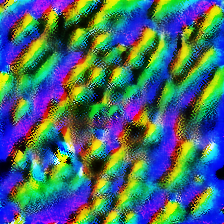
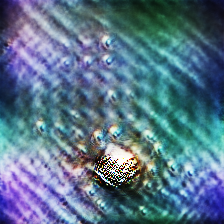
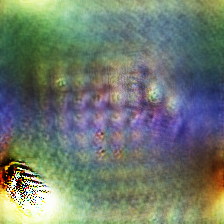
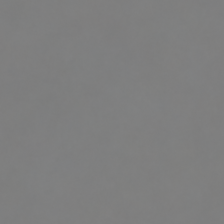
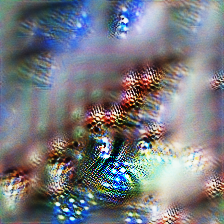
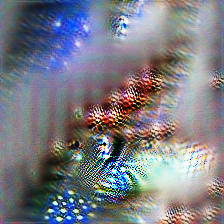
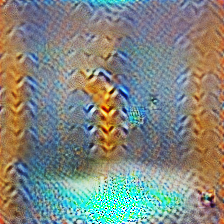
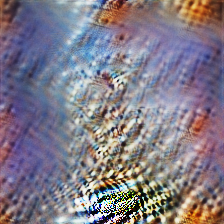
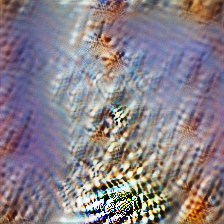
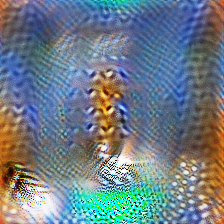

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0], batch = 0) + objectives.channel(layers[0],channel_list[0], batch = len(layers))

for i, layer in enumerate(layers):
  if i == 0:
    continue

  obj += objectives.channel(layer,channel_list[i], batch = i) + objectives.channel(layer,channel_list[i], batch = len(layers))
  
_ = render.render_vis(model, obj, param_f, preprocess = False, show_inline = True, fixed_image_size=(224,224), thresholds=(512,))

### Tiger cat

In [ ]:
channel_list = []
layer = '1'
layers = [ 'vit_encoder_layer_'+layer+'_attention_attention_query',
 'vit_encoder_layer_'+layer+'_attention_attention_key',
 'vit_encoder_layer_'+layer+'_attention_attention_value',
 'vit_encoder_layer_'+layer+'_attention_attention_dropout',
 'vit_encoder_layer_'+layer+'_attention_output_dense',
 'vit_encoder_layer_'+layer+'_attention_output_dropout',
 'vit_encoder_layer_'+layer+'_intermediate_dense',
 'vit_encoder_layer_'+layer+'_output_dense',
 'vit_encoder_layer_'+layer+'_output_dropout',
 ]

label = 'tiger cat'

for l in layers:
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  if len(attr.shape) == 2:
    channel_list.append(attr.max(-1)[1].item())
  elif len(attr.shape) == 3:
    channel_list.append(attr.max(-1)[0].max(-1)[1].item())

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[171, 147, 173, 0, 171, 171, 171, 171, 171]


100%|██████████| 512/512 [00:27<00:00, 18.57it/s]



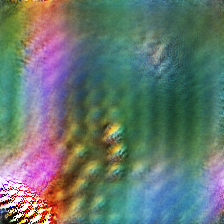
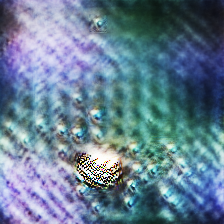
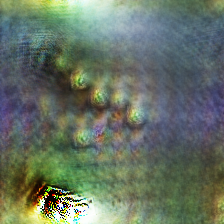
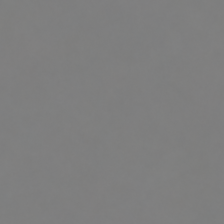
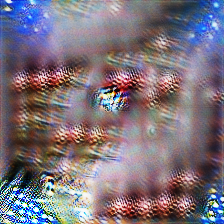
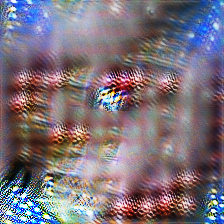
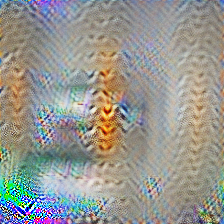
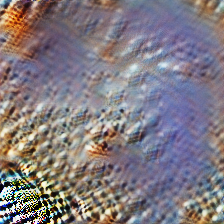
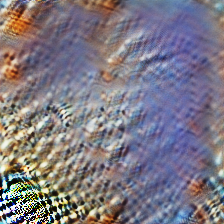
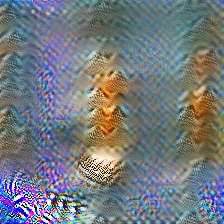

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0], batch = 0) + objectives.channel(layers[0],channel_list[0], batch = len(layers))

for i, layer in enumerate(layers):
  if i == 0:
    continue

  obj += objectives.channel(layer,channel_list[i], batch = i) + objectives.channel(layer,channel_list[i], batch = len(layers))
  
_ = render.render_vis(model, obj, param_f, preprocess = False, show_inline = True, fixed_image_size=(224,224), thresholds=(512,))

## Maximally activating channels in layer 11

### Labrador retriever

In [ ]:
channel_list = []
layer = '11'
layers = [ 'vit_encoder_layer_'+layer+'_attention_attention_query',
 'vit_encoder_layer_'+layer+'_attention_attention_key',
 'vit_encoder_layer_'+layer+'_attention_attention_value',
 'vit_encoder_layer_'+layer+'_attention_attention_dropout',
 'vit_encoder_layer_'+layer+'_attention_output_dense',
 'vit_encoder_layer_'+layer+'_attention_output_dropout',
 'vit_encoder_layer_'+layer+'_intermediate_dense',
 'vit_encoder_layer_'+layer+'_output_dense',
 'vit_encoder_layer_'+layer+'_output_dropout',
 ]

label = 'Labrador retriever'

for l in layers:
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  if len(attr.shape) == 2:
    channel_list.append(attr.max(-1)[1].item())
  elif len(attr.shape) == 3:
    channel_list.append(attr.max(-1)[0].max(-1)[1].item())

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[1, 123, 81, 10, 1, 1, 1, 1, 1]


100%|██████████| 512/512 [00:55<00:00,  9.23it/s]



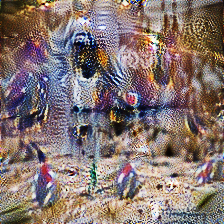
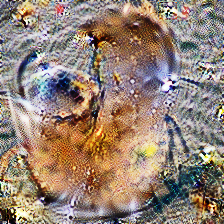
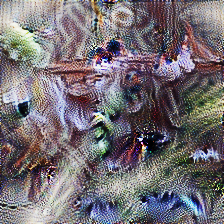
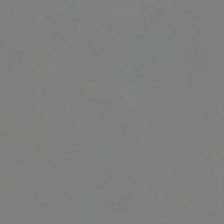
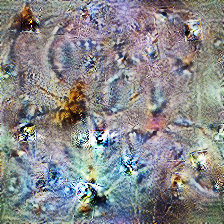
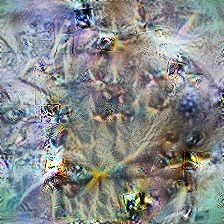
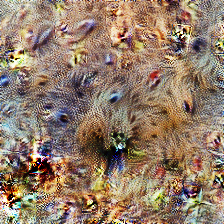
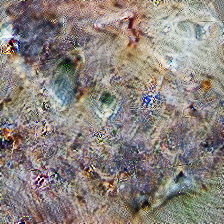
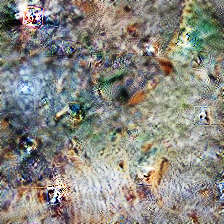
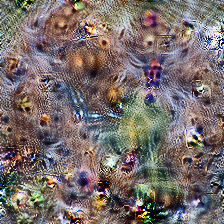

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0], batch = 0) + objectives.channel(layers[0],channel_list[0], batch = len(layers))

for i, layer in enumerate(layers):
  if i == 0:
    continue

  obj += objectives.channel(layer,channel_list[i], batch = i) + objectives.channel(layer,channel_list[i], batch = len(layers))
  
_ = render.render_vis(model, obj, param_f, preprocess = False, show_inline = True, fixed_image_size=(224,224), thresholds=(512,))

### Tiger cat

In [ ]:
channel_list = []
layer = '11'
layers = [ 'vit_encoder_layer_'+layer+'_attention_attention_query',
 'vit_encoder_layer_'+layer+'_attention_attention_key',
 'vit_encoder_layer_'+layer+'_attention_attention_value',
 'vit_encoder_layer_'+layer+'_attention_attention_dropout',
 'vit_encoder_layer_'+layer+'_attention_output_dense',
 'vit_encoder_layer_'+layer+'_attention_output_dropout',
 'vit_encoder_layer_'+layer+'_intermediate_dense',
 'vit_encoder_layer_'+layer+'_output_dense',
 'vit_encoder_layer_'+layer+'_output_dropout',
 ]

label = 'tiger cat'

for l in layers:
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  if len(attr.shape) == 2:
    channel_list.append(attr.max(-1)[1].item())
  elif len(attr.shape) == 3:
    channel_list.append(attr.max(-1)[0].max(-1)[1].item())

  for handle in handles:
    handle.remove()

In [ ]:
print(channel_list)

[0, 82, 95, 9, 1, 1, 0, 0, 0]


100%|██████████| 512/512 [00:55<00:00,  9.18it/s]



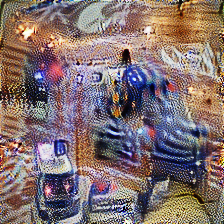
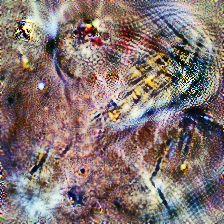
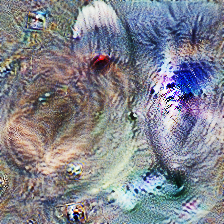
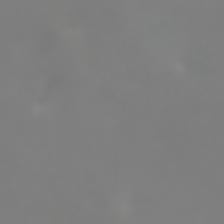
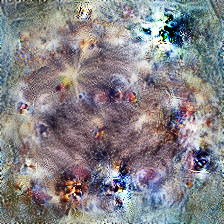
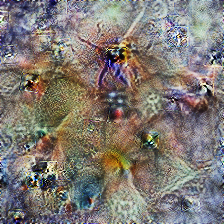
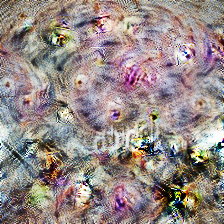
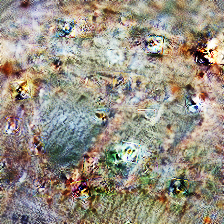
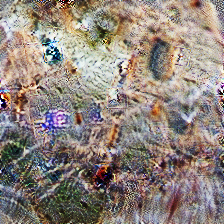
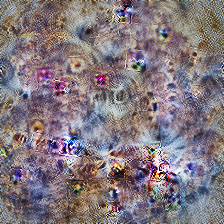

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0], batch = 0) + objectives.channel(layers[0],channel_list[0], batch = len(layers))

for i, layer in enumerate(layers):
  if i == 0:
    continue

  obj += objectives.channel(layer,channel_list[i], batch = i) + objectives.channel(layer,channel_list[i], batch = len(layers))
  
_ = render.render_vis(model, obj, param_f, preprocess = False, show_inline = True, fixed_image_size=(224,224), thresholds=(512,))

## Demo: Change layers and labels

100%|██████████| 512/512 [00:37<00:00, 13.74it/s]



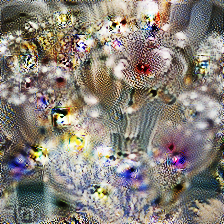
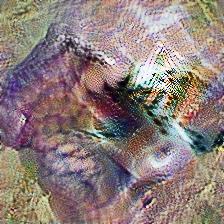
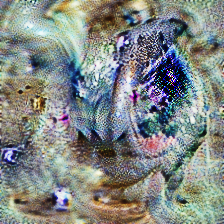
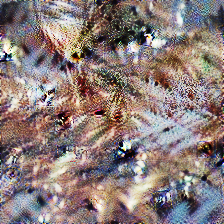
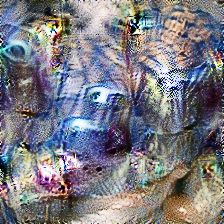
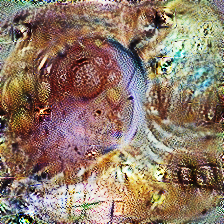
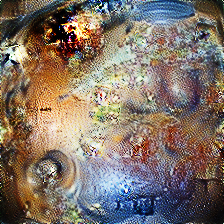
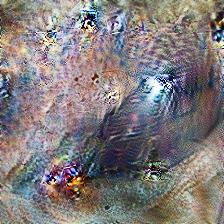

In [ ]:
channel_list = []
layer = '8' # Change to anything from 0 to 11
layers = [ 'vit_encoder_layer_'+layer+'_attention_attention_query',
 'vit_encoder_layer_'+layer+'_attention_attention_key',
 'vit_encoder_layer_'+layer+'_attention_attention_value',
 'vit_encoder_layer_'+layer+'_attention_output_dense',
 'vit_encoder_layer_'+layer+'_intermediate_dense',
 'vit_encoder_layer_'+layer+'_output_dense',
 'vit_encoder_layer_'+layer+'_output_dropout',
 ]

label = 'Labrador retriever' # Change between 'Labrador retriever' and 'tiger cat'

for l in layers:
  model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to('cpu').eval()

  activations = collections.defaultdict(list)
  handles = []

  def save_activation(activations, name, mod, inp, out):
    activations[name].append(out)

  for n, m in model.named_modules():
    handle = m.register_forward_hook(partial(save_activation, activations, n))
    handles.append(handle)

  img = np.array(Image.open('/content/dog_cat.jpeg'), np.float32)
  img = img / 255
  attr = raw_class_spatial_attr(img=img, layer=l, label=label)

  if len(attr.shape) == 2:
    channel_list.append(attr.max(-1)[1].item())
  elif len(attr.shape) == 3:
    channel_list.append(attr.max(-1)[0].max(-1)[1].item())

  for handle in handles:
    handle.remove()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device).eval()

param_f = lambda: param.image(224, batch=len(layers)+1)

obj = objectives.channel(layers[0],channel_list[0], batch = 0) + objectives.channel(layers[0],channel_list[0], batch = len(layers))

for i, layer in enumerate(layers):
  if i == 0:
    continue

  obj += objectives.channel(layer,channel_list[i], batch = i) + objectives.channel(layer,channel_list[i], batch = len(layers))
  
_ = render.render_vis(model, obj, param_f, preprocess = False, show_inline = True, fixed_image_size=(224,224), thresholds=(512,))